In [1]:
import torch
import torch.nn as nn
from lark.tools import lalr_argparser
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [2]:
datadf = pd.read_csv("./riceClassification.csv")

In [3]:
datadf

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18180,18181,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,18182,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,18183,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,18184,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [4]:
#remove unecessary columns
# here id is not req for training
#drop all rows containing nan values
datadf.dropna(inplace=True)
datadf.drop(['id'],axis=1,inplace=True)
datadf

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1
...,...,...,...,...,...,...,...,...,...,...,...
18180,5853,148.624571,51.029281,0.939210,6008,86.326537,0.498594,332.960,0.663444,2.912535,0
18181,7585,169.593996,58.141659,0.939398,7806,98.272692,0.647461,385.506,0.641362,2.916910,0
18182,6365,154.777085,52.908085,0.939760,6531,90.023162,0.561287,342.253,0.682832,2.925396,0
18183,5960,151.397924,51.474600,0.940427,6189,87.112041,0.492399,343.371,0.635227,2.941216,0


In [5]:
datadf['Class'].value_counts()

Class
1    9985
0    8200
Name: count, dtype: int64

In [6]:
#divide the rows ny the largest data in each column to get values btw 0 and 1

originaldf = datadf.copy()
for columns in datadf.columns:
    datadf[columns] = datadf[columns]/datadf[columns].abs().max()
datadf

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0
...,...,...,...,...,...,...,...,...,...,...,...
18180,0.573262,0.811219,0.618156,0.971489,0.545785,0.757140,0.562384,0.654774,0.733291,0.744543,0.0
18181,0.742899,0.925674,0.704314,0.971683,0.709121,0.861916,0.730296,0.758107,0.708884,0.745661,0.0
18182,0.623408,0.844800,0.640916,0.972058,0.593296,0.789562,0.633098,0.673049,0.754720,0.747830,0.0
18183,0.583741,0.826356,0.623551,0.972748,0.562227,0.764030,0.555396,0.675248,0.702103,0.751874,0.0


In [7]:
x = np.array(datadf.iloc[:,:-1])
y = np.array(datadf.iloc[:,-1])

In [8]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.3)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,test_size=0.5)

In [9]:
class dataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32).to(device)
        self.y = torch.tensor(y, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]


In [10]:
trainingdata = dataset(xtrain, ytrain)
testdata = dataset(xtest, ytest)
validationdata = dataset(xval, yval)

In [11]:
traindataloader = DataLoader(trainingdata, batch_size=8, shuffle=True)
testdataloader = DataLoader(testdata, batch_size=8, shuffle=True)
validationdataloader = DataLoader(validationdata, batch_size=8, shuffle=True)

In [12]:
for x,y in traindataloader:
    print(x.shape, y.shape)

torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Size([8])
torch.Size([8, 10]) torch.Si

In [13]:
class mymodel(nn.Module):
    def __init__(self):
        super(mymodel, self).__init__()
        self.inputlayer = nn.Linear(
            in_features=x.shape[1],
            out_features=10,
        )
        self.linear = nn.Linear(10,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.inputlayer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model0 = mymodel().to(device)

In [14]:
summary(model0.cpu(),(x.shape[1],))
model0 = mymodel().to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [15]:
print(model0)

mymodel(
  (inputlayer): Linear(in_features=10, out_features=10, bias=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
criteria = nn.BCELoss()

In [17]:
optimizer = Adam(model0.parameters(), lr=1e-3)

In [18]:
totallosstrainplot = []
totallossvalplot = []
totalacctrainplot = []
totalaccvalplot =[]

epochs = 10
for epoch in range(epochs):
    totalacctrain = 0
    totallosstrain = 0
    totalaccval = 0
    totallossval =0

    for data in traindataloader:
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        pred = model0(inputs).squeeze(1)
        loss = criteria(pred, labels)
        totallosstrain = totallosstrain + loss.item()
        acc = ((pred).round()==labels).sum().item()
        totalacctrain = totalacctrain + acc
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    with torch.no_grad():
        for data in validationdataloader:
            inputs,labels = data
            pred = model0(inputs).squeeze(1)
            loss = criteria(pred, labels)
            totallossval = totallossval + loss.item()
            acc = ((pred).round() ==labels).sum().item()
            totalaccval = totalaccval + acc
    totallosstrainplot.append(round(totallosstrain/1000,4))
    totallossvalplot.append(round(totallossval/1000,4))
    totalacctrainplot.append(round(totalacctrain/trainingdata.__len__()*100,4))
    totalaccvalplot.append(round(totalaccval/validationdata.__len__()*100,4))

    print(f'\n epoch : {epoch} total train loss: {round(totallosstrain/1000,4)}, total train acc1: {round(totalacctrain/trainingdata.__len__()*100,4)}, total train acc: {round(totallossval/1000,4)} , total val acc: {round(totalaccval/validationdata.__len__()*100,4)} ')


 epoch : 0 total train loss: 0.657, total val loss: 90.337, total train acc: 0.0491 , total val acc: 98.3138 

 epoch : 1 total train loss: 0.1466, total val loss: 98.5309, total train acc: 0.0215 , total val acc: 98.2771 

 epoch : 2 total train loss: 0.0891, total val loss: 98.6566, total train acc: 0.0152 , total val acc: 98.5337 

 epoch : 3 total train loss: 0.0755, total val loss: 98.5781, total train acc: 0.0135 , total val acc: 98.717 

 epoch : 4 total train loss: 0.0714, total val loss: 98.5702, total train acc: 0.014 , total val acc: 98.3504 

 epoch : 5 total train loss: 0.0699, total val loss: 98.5781, total train acc: 0.0146 , total val acc: 98.3871 

 epoch : 6 total train loss: 0.0687, total val loss: 98.6095, total train acc: 0.0123 , total val acc: 98.717 

 epoch : 7 total train loss: 0.0679, total val loss: 98.5545, total train acc: 0.0127 , total val acc: 98.5337 

 epoch : 8 total train loss: 0.0672, total val loss: 98.633, total train acc: 0.0121 , total val acc

In [19]:
with torch.no_grad():
    totallosstest =0
    totalacctest=0
    for data in testdataloader:
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        pred = model0(inputs).squeeze(1)
        loss = criteria(pred, labels).item()
        totallosstest = totallosstest + loss
        acc = ((pred).round()==labels).sum().item()
        totalacctest = totalacctest + acc

print(f'accuracy : {round(totalacctest/testdata.__len__()*100,4)}')

accuracy : 98.607


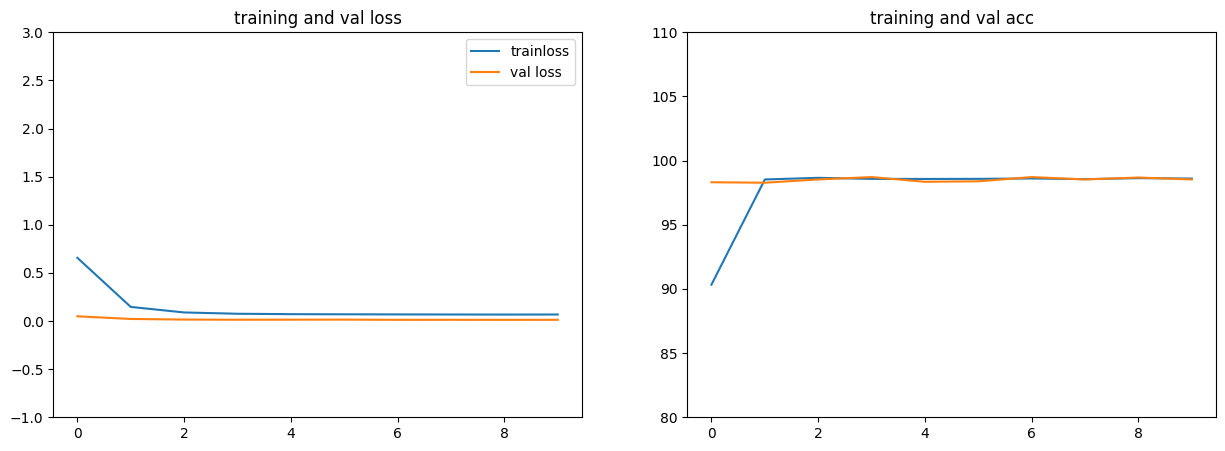

In [33]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

ax[0].plot(totallosstrainplot,label='trainloss')
ax[0].plot(totallossvalplot,label='val loss')
ax[0].set_title("training and val loss")
ax[0].set_ylim(-1,3)
ax[0].legend()

ax[1].plot(totalacctrainplot,label='trainloss')
ax[1].plot(totalaccvalplot,label='val loss')
ax[1].set_title("training and val acc")
ax[1].set_ylim(80,110)
ax[0].legend()

plt.show()